<a href="https://colab.research.google.com/github/RvMerle/RvMerle/blob/main/Presentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Data Collection & Analysis

##Collecting our Dataset
During the EDA, we first started out with [this](https://www.kaggle.com/gpreda/reddit-wallstreetsbets-posts) kaggle dataset. However, we found that dataset to be unsatisfactory, as it only contained a subset of the posts for each day, and the number of posts was not enough to properly train a model. Hence, we decided to collect our own dataset. Reddit's default API only allowed us to extract the last 1000 posts, so we used the [pushshift.io](https://pushshift.io/) API instead.

In [ ]:
%tensorflow_version 1.x
import pandas as pd
import numpy as np
import requests
import datetime
import time
import urllib

TensorFlow 1.x selected.


In [ ]:
def pushshift_get_ratelimit():
    """
    Get the rate limit in requests/minute for the pushshift API.
    """
    r = requests.get('https://api.pushshift.io/meta')
    try:
        ratelimit = r.json()['server_ratelimit_per_minute']
    except:
        print('Something went wrong when decoding the json response: status code', r.status_code)
        print(r.text)
        time.sleep(1)
        print('Trying again...')
        return pushshift_get_ratelimit()
    return ratelimit


def pushshift_get_posts(subreddit, after, ratelimit=120, size=100):
    """
    Get a number of posts from the pushshift API, and return the creation time,
    number of comments, score and text of each posts. The creation time of the
    last post can be used as starting post for the next call of this function.
    """
    params = {
        'after': after,
        'fields': 'created_utc,num_comments,score,selftext,title',
        'is_self': 'true',
        'selftext:not': '[removed]',
        'size': size,
        'subreddit': subreddit,
        'user_removed': 'false',
        'mod_removed': 'false'
    }
    params_str = urllib.parse.urlencode(params, safe=',:[]')

    r = requests.get('https://api.pushshift.io/reddit/submission/search', params=params_str)
    time.sleep(60/ratelimit)
    try:
        json_response = r.json()['data']
    except:
        print('Something went wrong when decoding the json response: status code', r.status_code)
        print('URL:', r.url)
        print(r.text)
        time.sleep(60/ratelimit)
        print('Trying again...')
        return pushshift_get_posts(subreddit, after, ratelimit=ratelimit, size=size)
    return json_response


def pushshift_write_csv(subreddit, after_date, file='reddit.csv', ratelimit=120):
    """Get all reddit posts since a certain date and write them to a csv file."""
    json_response = pushshift_get_posts(subreddit, after=after_date, ratelimit=ratelimit)

    df = pd.DataFrame.from_dict(json_response)
    df['created_utc'] = pd.to_datetime(df['created_utc'], unit='s')
    df.to_csv(file)

    while len(json_response)==100:
        json_response = pushshift_get_posts(subreddit, after=json_response[-1]['created_utc'], ratelimit=ratelimit)

        df = pd.DataFrame.from_dict(json_response)
        df['created_utc'] = pd.to_datetime(df['created_utc'], unit='s')
        df.to_csv(file, mode='a', header=False)
        
        print(df.iloc[-1, 0])

    print('Done! Your file is written to', file)

In [ ]:
# Get the ratelimit of the Pushshift API
ratelimit = pushshift_get_ratelimit()
print('Pushshift ratelimit:', ratelimit)

# The 'pushshift_write_csv' method can be used to download and export all submissions
# since 1 Jan 2021. This takes a very long time however (think ~30 minutes), so
# in this case we just import the csv that we already scraped
date_begin  = int(datetime.datetime(2021,1,1,0,0).timestamp())
#pushshift_write_csv('wallstreetbets', date_begin, 'reddit (self scraped).csv', ratelimit)

# File we scraped ourselves
df_wsb = pd.read_csv('https://drive.google.com/uc?export=download&id=1i5IVrxoJ8GgoCZbiDclvVRhhFaEksOxj', index_col=0, parse_dates=['created_utc'])
df_wsb.head(10)

Pushshift ratelimit: 120


,created_utc,num_comments,score,selftext,title
0,2021-01-01 00:02:06,20,1,https://preview.redd.it/jwfh65wgyf861.png?widt...,"3k - 170k since March (Also, buy LIT!!)"
1,2021-01-01 00:05:29,5,1,We all know the short volume far exceeds 100% ...,"GME to 420.69, but only if we make it happen. ..."
2,2021-01-01 00:15:38,19,1,Every time a new submission is posted to walls...,WSBVoteBot Log for Jan 01 2021
3,2021-01-01 00:21:47,0,1,You guys are my favorite dipshits making cash....,Professional WSB handler here
4,2021-01-01 00:27:44,0,1,When I first started investing I was learning ...,Missed out on 2020 because of long term fuckers
5,2021-01-01 00:41:31,13,1,Is it only major banks financing auto loans? S...,Sub-Prime Auto Loan Puts
6,2021-01-01 00:45:03,8,1,"""Comrades, friends, ladies and gentlemen, gree...",Full text of Xi Jinping's 2021 New Year address
7,2021-01-01 00:49:32,0,1,"Gamestop colors: Red, White and Black\n\nHoust...",🚀🚀🚀🚀How have we been so fucking blind? GME is ...
8,2021-01-01 00:54:01,24,1,I just hit $.07 per month!\n\nSo after my depo...,I just hit $.07 per month!
9,2021-01-01 00:56:35,11,1,"Gamestop colors: Red, White and Black\n\nHoust...",GME is the Rockets 🚀🚀🚀🚀


##Initial Analysis
Let's have a look at the dataset we just scraped, and fix some common issues.

In [ ]:
# There are a lot of null values for the selftext (which is the body of the post)
# and the title. This usually means the post only contained an image / link to
# external article.
df_wsb.isna().sum()

created_utc         0
num_comments        0
score               0
selftext        22338
title           22457
dtype: int64

In [ ]:
# Look at the most common values for the body & title
df_wsb['selftext'].value_counts()

[deleted]                                                                                                                                                                                                                                                                                                                                                                                                                                  1069
Title                                                                                                                                                                                                                                                                                                                                                                                                                                        51
🚀🚀🚀                                                                                                                                     

In [ ]:
df_wsb['title'].value_counts()

[deleted]                                                                                                                                                                      953
AMC                                                                                                                                                                            354
NOK                                                                                                                                                                            228
GME                                                                                                                                                                            195
SNDL                                                                                                                                                                           100
                                                                                                         

In [ ]:
# Remove any rows that don't have a body
df_wsb = df_wsb.dropna(subset=['selftext'], axis=0)

# Replace missing titles with an empty string
df_wsb['title'] = df_wsb['title'].fillna('')

# Remove posts that are removed / deleted
df_wsb = df_wsb.loc[(df_wsb['selftext'] != '[removed]') & (df_wsb['selftext'] != '[deleted]')]
df_wsb = df_wsb.loc[(df_wsb['title'] != '[removed]') & (df_wsb['title'] != '[deleted]')]

# Extract date from created_utc column
df_wsb['date'] = df_wsb['created_utc'].dt.date

df_wsb.head()

,created_utc,num_comments,score,selftext,title,date
0,2021-01-01 00:02:06,20,1,https://preview.redd.it/jwfh65wgyf861.png?widt...,"3k - 170k since March (Also, buy LIT!!)",2021-01-01
1,2021-01-01 00:05:29,5,1,We all know the short volume far exceeds 100% ...,"GME to 420.69, but only if we make it happen. ...",2021-01-01
2,2021-01-01 00:15:38,19,1,Every time a new submission is posted to walls...,WSBVoteBot Log for Jan 01 2021,2021-01-01
3,2021-01-01 00:21:47,0,1,You guys are my favorite dipshits making cash....,Professional WSB handler here,2021-01-01
4,2021-01-01 00:27:44,0,1,When I first started investing I was learning ...,Missed out on 2020 because of long term fuckers,2021-01-01


In [ ]:
df_wsb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99046 entries, 0 to 6
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   created_utc   99046 non-null  datetime64[ns]
 1   num_comments  99046 non-null  int64         
 2   score         99046 non-null  int64         
 3   selftext      99046 non-null  object        
 4   title         99046 non-null  object        
 5   date          99046 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 5.3+ MB


So concluding, we have found 99k useful posts to analyse over a 3-month period!

# Extract Stock Market Tickers
The first thing to find out is what stock a post is talking about. We try to match any of the tickers from the NYSE and NASDAQ in a smart way.

In [ ]:
import re
import string
from collections import Counter

##Load All Tickers from NYSE and NASDAQ
Source: https://www.nasdaqtrader.com/trader.aspx?id=symboldirdefs

In [ ]:
# Load all tickers from NYSE and NASDAQ
df_tickers_nyse = pd.read_table('ftp://ftp.nasdaqtrader.com/symboldirectory/otherlisted.txt', sep='|')
df_tickers_nyse = df_tickers_nyse[['ACT Symbol', 'Security Name']]
df_tickers_nyse.columns = ['Symbol', 'Company Name']
df_tickers_nyse.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5882 entries, 0 to 5881
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Symbol        5882 non-null   object
 1   Company Name  5881 non-null   object
dtypes: object(2)
memory usage: 92.0+ KB


In [ ]:
df_tickers_nasdaq = pd.read_table('ftp://ftp.nasdaqtrader.com/symboldirectory/nasdaqlisted.txt', sep='|')
df_tickers_nasdaq = df_tickers_nasdaq[['Symbol', 'Security Name']]
df_tickers_nasdaq.columns = ['Symbol', 'Company Name']
df_tickers_nasdaq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4451 entries, 0 to 4450
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Symbol        4451 non-null   object
 1   Company Name  4450 non-null   object
dtypes: object(2)
memory usage: 69.7+ KB


In [ ]:
# Combine the tickers together in one set
df_tickers_nyse['Symbol'].str.upper()
df_tickers_nasdaq['Symbol'].str.upper()
tickers = set(df_tickers_nyse['Symbol']) | set(df_tickers_nasdaq['Symbol'])
print(len(tickers), 'tickers')

10333 tickers


##Extract Ticker from Text
Now we can start reading the ticker from each post.

In [ ]:
def get_ticker(row, tickers):
    """
    Returns the ticker that's mentioned the most in a post, and None if we can't
    find any ticker listed on the NYSE. It follows the following step-plan:
    1. Find any 3-6 character string that start with $ in the title and posts,
       and check if it's in the tickers set. If yes, return the one with the
       highest occurence.
    2. Find all 2-5 character strings with only uppercase letters, first in the
       post and then in the title, and check if it's in the tickers set. If yes,
       return the one with the highest occurence.
    3. We didn't find a ticker, return None.
       (We can potentially still improve this by doing a reverse lookup of company names.)
    """
    post = row[0]
    title = row[1]

    # Split by every possible delimiter except $ and remove words of wrong length
    words_post = [word for word in re.split(r'[^a-zA-Z0-9_$]+', post)]
    words_title = [word for word in re.split(r'[^a-zA-Z0-9_$]+', title)]

    # 1. Check all words in post and title that start with $
    possible_tickers_dollar = [word[1:].upper() for word in words_post + words_title if word.startswith('$') and 3<=len(word)<=6 and (word[1:].islower() or word[1:].isupper()) and word[1:].upper() in tickers]
    occurences_dollar = Counter(possible_tickers_dollar)
    max_occurences_dollar = max(occurences_dollar.values(), default=-1)
    tickers_dollar = [ticker for ticker, occurence in occurences_dollar.items() if occurence == max_occurences_dollar]
    if len(tickers_dollar) == 1:
        return tickers_dollar[0]
    
    # 2.a Check all uppercase words with length 2-5 in post
    possible_tickers_uppercase_post = [word for word in words_post if  not word.startswith('$') and 2<=len(word)<=5 and word.isupper() and word in tickers] + possible_tickers_dollar
    occurences_uppercase_post = Counter(possible_tickers_uppercase_post)
    max_occurences_uppercase_post = max(occurences_uppercase_post.values(), default=-1)
    tickers_uppercase_post = [ticker for ticker, occurence in occurences_uppercase_post.items() if occurence == max_occurences_uppercase_post]
    if len(tickers_uppercase_post) == 1:
        return tickers_uppercase_post[0]
    
    # 2.b Check all uppercase words with length 2-5 in title
    possible_tickers_uppercase_all = [word for word in words_title if  not word.startswith('$') and 2<=len(word)<=5 and word.isupper() and word in tickers] + possible_tickers_uppercase_post
    occurences_uppercase_all = Counter(possible_tickers_uppercase_all)
    max_occurences_uppercase_all = max(occurences_uppercase_all.values(), default=-1)
    tickers_uppercase_all = [ticker for ticker, occurence in occurences_uppercase_all.items() if occurence == max_occurences_uppercase_all]
    if len(tickers_uppercase_all) == 1:
        return tickers_uppercase_all[0]
        
    # 3. No ticker found, return None
    return None

In [ ]:
# Drop some tickers that are likely to become false-positives
tickers -= {'IT', 'FOR', 'SO', 'MY', 'CEO', 'AM', 'BIG', 'TIME', 'ARE', 'ALL', 'DO', 'AT', 'MORE', 'NOW', 'AN', 'OUT', 'ONE', 'SEE', 'TOO', 'TWO', 'PAY', 'EVER', 'AGO', 'LOW', 'BIT', 'HE', 'PER', 'STAY', 'DATA', 'KEY', 'IM', 'FUN', 'EAT', 'RE', 'LL', 'WWW', 'MAN', 'MAIN', 'CAP', 'GOV', 'RATE', 'PRE', 'POST', 'HAS', 'CALl', 'NEWS', 'ANY', 'LINE', 'LOOK', 'GOOD', 'ELSE', 'FULL', 'SALE', 'LONG', 'WIN', 'HEAR', 'PLAY', 'SALE', 'AWAY', 'FUND', 'FAST', 'GAIN', 'CALL', 'TRUE', 'BEAT', 'RENT', 'COST', 'PLUS', 'MIND', 'HOT', 'GAME', 'FREE', 'ON', 'BE', 'HOLD', 'JUST', 'CAN', 'AUTO', 'GO', 'OR', 'COM', 'NEW', 'WHAT', 'NEXT', 'EDIT', 'OPEN', 'LOVE', 'HUGE', 'REAL', 'BY', 'DD', 'RH', 'MOON'}

# Extract tickers from each post
df_wsb['ticker'] = df_wsb[['selftext', 'title']].apply(lambda row: get_ticker(row, tickers), axis=1)
df_wsb['ticker'].value_counts()

GME     20705
AMC      5001
NOK      2187
BB       2043
SNDL      670
        ...  
CRNT        1
BTBT        1
HJLI        1
IZEA        1
KIN         1
Name: ticker, Length: 1948, dtype: int64

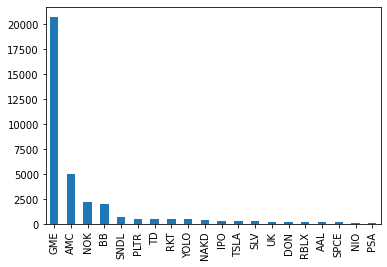

In [ ]:
# Remove any rows for which we didn't find a ticker
df_wsb.dropna(subset=['ticker'], axis=0, inplace=True)

# Make a nice bar graph
df_wsb['ticker'].value_counts().head(20).plot.bar()

In [ ]:
len(df_wsb)

46951

So from almost 100k initial posts, we managed to extract a ticker for almost 47k of them!

##Test Extraction Algorithm
Some functions to evaluate how well our algorithm works

In [ ]:
import random

def count_tickers(row, tickers):
    """
    Copy and adaptation of get_ticker, counts and prints the number of times a ticker occuercs
    """
    post = row[0]
    title = row[1]
    
    # Split by every possible delimiter except $ and remove words of wrong length
    words_post = [word for word in re.split(r'[^a-zA-Z0-9_$]+', post)]
    words_title = [word for word in re.split(r'[^a-zA-Z0-9_$]+', title)]
    
    possible_tickers_dollar = [word[1:].upper() for word in words_post + words_title if word.startswith('$') and 3<=len(word)<=6 and (word[1:].islower() or word[1:].isupper()) and word[1:].upper() in tickers]
    possible_tickers_uppercase_post = [word for word in words_post if not word.startswith('$') and 2<=len(word)<=5 and word.isupper() and word in tickers] + possible_tickers_dollar
    possible_tickers_uppercase_all = [word for word in words_title if not word.startswith('$') and 2<=len(word)<=5 and word.isupper() and word in tickers] + possible_tickers_uppercase_post

    occurences = Counter(possible_tickers_uppercase_all)
    print(occurences)

In [ ]:
i = random.randrange(len(df_wsb))
print('ID:', i, '- Ticker:', get_ticker(df_wsb.iloc[i][['selftext', 'title']], tickers), '- Title:', df_wsb.iloc[i]['title'])
count_tickers(df_wsb.iloc[i][['selftext', 'title']], tickers)
print(df_wsb.iloc[i]['selftext'])

ID: 6274 - Ticker: GME - Title: GME
Counter({'GME': 1})
Everyone buy this dip we can push 150-200 again tomorrow


## Print Some Graphs

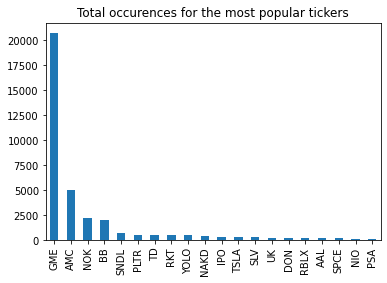

In [ ]:
# Most popular tickers
df_wsb['ticker'].value_counts().head(20).plot(kind='bar', title='Total occurences for the most popular tickers')

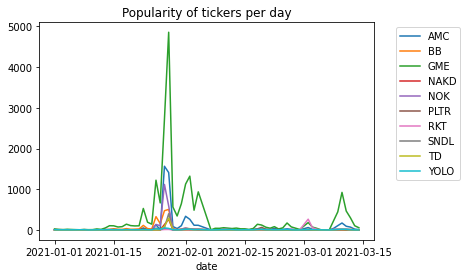

In [ ]:
# Popularity of tickers over time
top_tickers = set(df_wsb['ticker'].value_counts().head(10).index)

plot = df_wsb[df_wsb['ticker'].isin(top_tickers)].pivot_table(index=['date'], columns='ticker', aggfunc='size').fillna(0).plot(title='Popularity of tickers per day')
plot.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

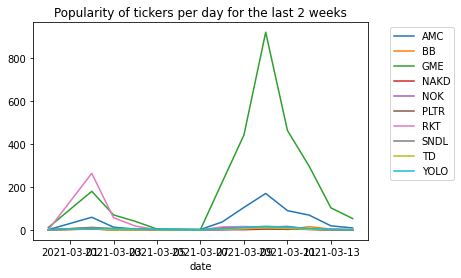

In [ ]:
# Same as above, but only for last two weeks
begin = df_wsb['date'].max() - pd.Timedelta(weeks=2)
plot = df_wsb[(df_wsb['ticker'].isin(top_tickers)) & (df_wsb['date']>=begin)].pivot_table(index=['date'], columns='ticker', aggfunc='size').fillna(0).plot(title='Popularity of tickers per day for the last 2 weeks')
plot.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

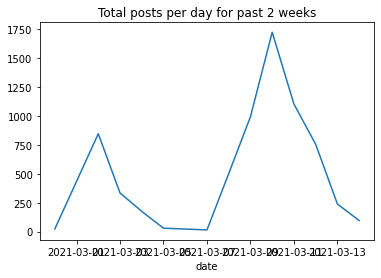

In [ ]:
# Total posts per day for which we could find a ticker
plot = df_wsb[df_wsb['date']>=begin].pivot_table(index=['date'], aggfunc='size').fillna(0).plot(title='Total posts per day for past 2 weeks')

# Sentiment Analysis
We will perform sentiment analysis with two separate models: VADER Sentiment and the BERT model.

##VADER Sentiment
VADER (Valence Aware Dictionary and Sentiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media.

###Sentiment Extraction

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Download VaderSentiment model
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()
nltk.download('stopwords')
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, HdpModel, LdaModel

# Spacy
import spacy
!pip install spacymoji
from spacymoji import Emoji

nlp = spacy.load("en_core_web_sm", disable=['parser'])
emoji = Emoji(nlp, merge_spans=False)
nlp.add_pipe(emoji, first=True)

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
     |████████████████████████████████| 51kB 3.6MB/s 
  Created wheel for emoji: filename=emoji-0.6.0-cp37-none-any.whl size=49716 sha256=f6d450d691d4e958af24af09f3a41fd0d0d4d2aabb5677b08ad68a658e198e4a
  Stored in directory: /root/.cache/pip/wheels/46/2c/8b/9dcf5216ca68e14e0320e283692dce8ae321cdc01e73e17796
Successfully built emoji


In [ ]:
def get_TextFeatures(df: pd.DataFrame):
    """Add features to dataframe"""
    #df['full_text'] = df['selftext'] + ' ' + df['title'].fillna('')
    df['text_lenght'] = df['selftext'].apply(lambda x: len(x))
    p = df.selftext.transform(VaderSentiment).to_list()
    df[['VS_pos','VS_neu','VS_neg','compound']] = pd.DataFrame(p, columns=['VS_pos','VS_neu','VS_neg','compound'])
    df['sentiment'] = df['compound'].apply(lambda c: 'pos' if c>0.1 else 'neg' if c<-0.1 else 'neu')
    df[['num_of_words','num_of_emojis']] = pd.DataFrame(df.selftext.apply(lambda x: NumbersFromText(x)).to_list(), columns=['num_of_words','num_of_emojis'])

def VaderSentiment(text: str):
    """Extract sentiment with VaderSentiment"""
    d = sid.polarity_scores(text)
    return d['pos'],d['neu'],d['neg'],d['compound']

def NumbersFromText(txt: str):
    """Calculate some text statistics using nltk"""
    try:
        doc = nlp(txt)
        words = [token.text for token in doc if token.is_alpha]
        emojis = [token.text for token in doc if token._.is_emoji]
        return len(words), len(emojis)
    except:
        return 0,0

In [ ]:
df_wsb_vader = df_wsb.copy()

# Once this is exucuted magic happens. However, it takes quite long (~10 min), so
# we ran the function once, and will just import the result.
#get_TextFeatures(df_wsb_vader)
df_wsb_vader = pd.read_csv('https://drive.google.com/uc?export=download&id=1j3fHTWHCuYMpmttXBVuYCNr64D7X1N45', index_col=0, parse_dates=['created_utc', 'date'])
df_wsb_vader.head()

,created_utc,num_comments,score,selftext,title,ticker,date,text_lenght,VS_pos,VS_neu,VS_neg,compound,sentiment,num_of_words,num_of_emojis
1,2021-01-01 00:05:29,5,1,We all know the short volume far exceeds 100% ...,"GME to 420.69, but only if we make it happen. ...",GME,2021-01-01,830,0.220,0.724,0.057,0.9996,pos,1094,0
6,2021-01-01 00:45:03,8,1,"""Comrades, friends, ladies and gentlemen, gree...",Full text of Xi Jinping's 2021 New Year address,GDP,2021-01-01,6845,0.042,0.878,0.080,-0.7391,neg,173,0
7,2021-01-01 00:49:32,0,1,"Gamestop colors: Red, White and Black\n\nHoust...",🚀🚀🚀🚀How have we been so fucking blind? GME is ...,GME,2021-01-01,929,0.110,0.846,0.044,0.9977,pos,1138,28
9,2021-01-01 00:56:35,11,1,"Gamestop colors: Red, White and Black\n\nHoust...",GME is the Rockets 🚀🚀🚀🚀,GME,2021-01-01,911,0.117,0.851,0.033,0.9867,pos,394,14
10,2021-01-01 01:04:23,35,1,"Okay hear me out, WE ALL ALREADY FUCKING HAVE ...",STOP POSTING GME DD🚀🚀🚀,GME,2021-01-01,395,0.108,0.892,0.000,0.7088,pos,62,0


###Plots

In [ ]:
!pip install yfinance
import yfinance as yf

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

     |████████████████████████████████| 5.5MB 17.9MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23442 sha256=fdc2ef5cf86b9c29cdb6bc30d413ad5202a51b2570f02f23dcadaef47a1b99af
  Stored in directory: /root/.cache/pip/wheels/f8/2a/0f/4b5a86e1d52e451757eb6bc17fd899629f0925c777741b6d04
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
# Make list of unique dates in order
dates = [str(date)[0:10] for date in df_wsb_vader['date']]
dates = list(dict.fromkeys(dates))

In [ ]:
def get_stock(ticker='GME'):
    """Returns a stock price for interval we need. Right now the period is
    hardcoded, so it will stop working at some point"""
    st = yf.Ticker(ticker)
    hist = st.history(period="4mo")
    return hist['Open'].iloc[12:]

def get_attitude(ticker='GME', df=df_wsb_vader):
    """Hype is a total popularity weighted with |sentiment|*number of upvotes,
    sentiment is total poluarity weighted with sentiment * number of upvotes for each day"""
    d = df[df['ticker']==ticker]
    sentiment = []
    hype = []
    for j in dates:
        date = d[d['date']==j]
        mood = [date.iloc[i]['compound']*date.iloc[i]['score'] for i in range(len(date))]
        sentiment.append(sum(mood))
        absolute_sentiment = [abs(i) for i in mood]
        hype.append(sum(absolute_sentiment))
    return sentiment, hype

def plot_mood(ticker, mood, name = 'Hype'): 
    """Plot the mood and stockprice together in one graph. This was hard, because
    stock exchange is closed on weekends and reddit isn't"""
    x_values2 = dates
    y_values2 = mood
    x_values1 = get_stock(ticker).keys()
    y_values1 = get_stock(ticker)

    fig=figure(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
    ax=fig.add_subplot(111, label="1")
    ax2=fig.add_subplot(111, label="2", frame_on=False)

    ax2.plot(x_values2, y_values2, color="g", label = name)
    ax2.xaxis.tick_top()
    ax2.yaxis.tick_right()

    ax2.set_ylabel('score', color="b")       
    ax2.xaxis.set_label_position('top') 
    ax2.yaxis.set_label_position('right') 
    ax2.tick_params(axis='x', colors="b")
    ax2.tick_params(axis='y', colors="b")
    ax2.set_xticks([])

    ax.plot(x_values1, y_values1, color="r", label = 'Stock price' , linewidth=3.0)
    ax.set_xlabel("time", color="b")
    ax.set_ylabel("price", color="b")
    ax.tick_params(axis='x', colors="b")
    ax.tick_params(axis='y', colors="b")

    plt.legend()
    plt.title('Stock price of ' + ticker +  ' and mood')
    plt.show()

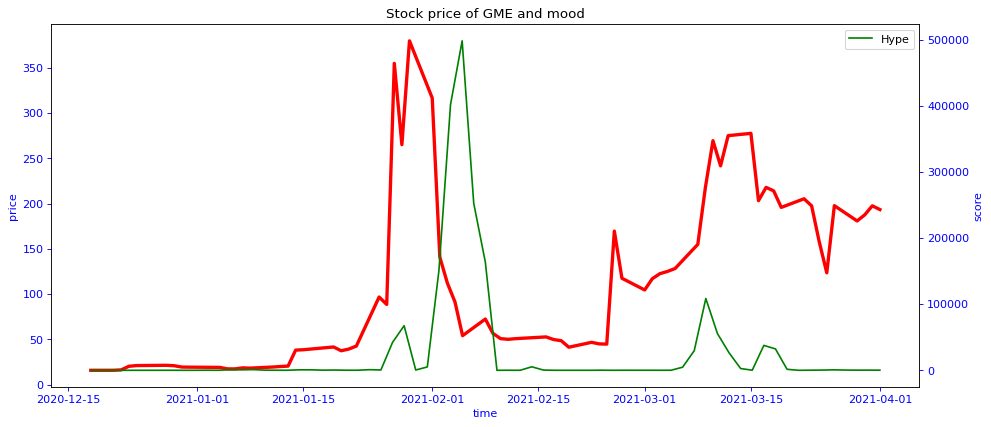

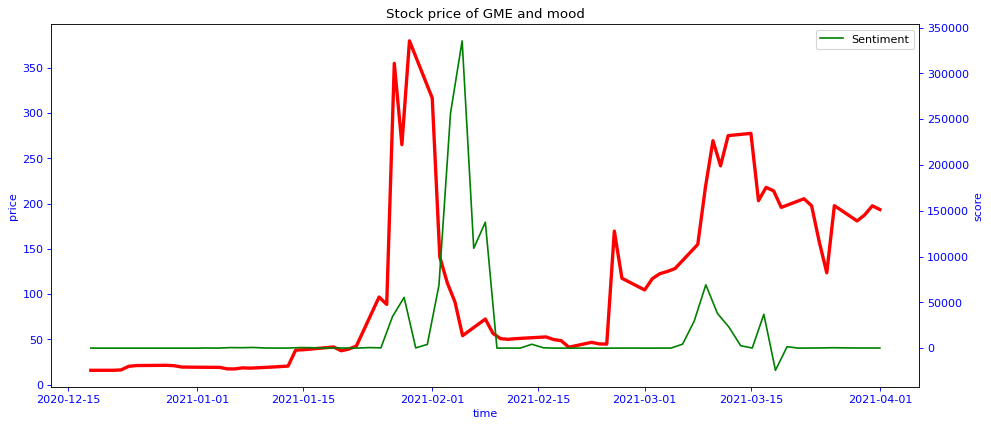

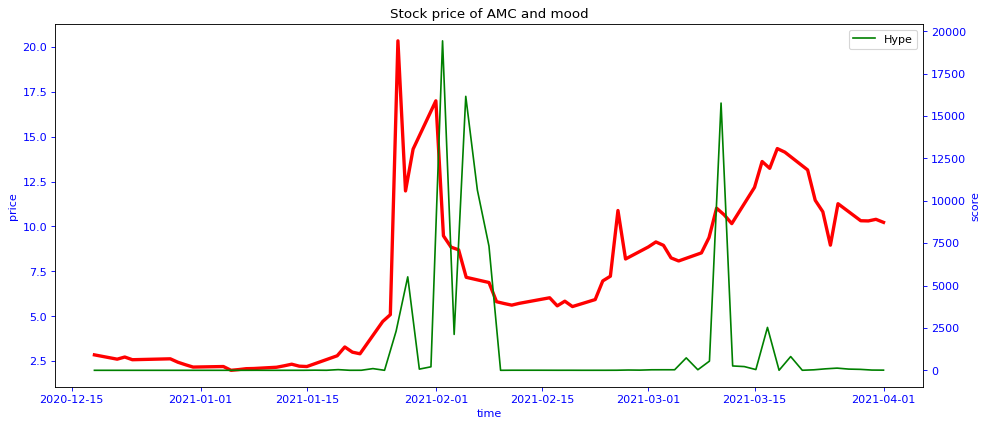

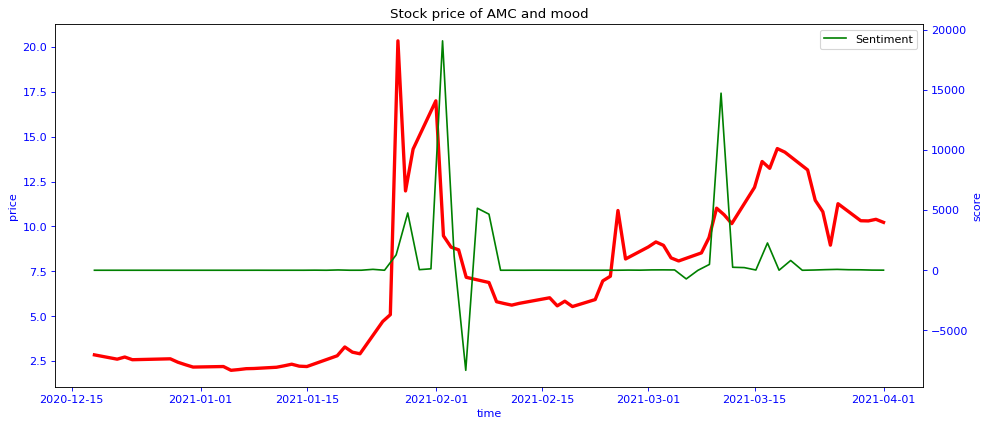

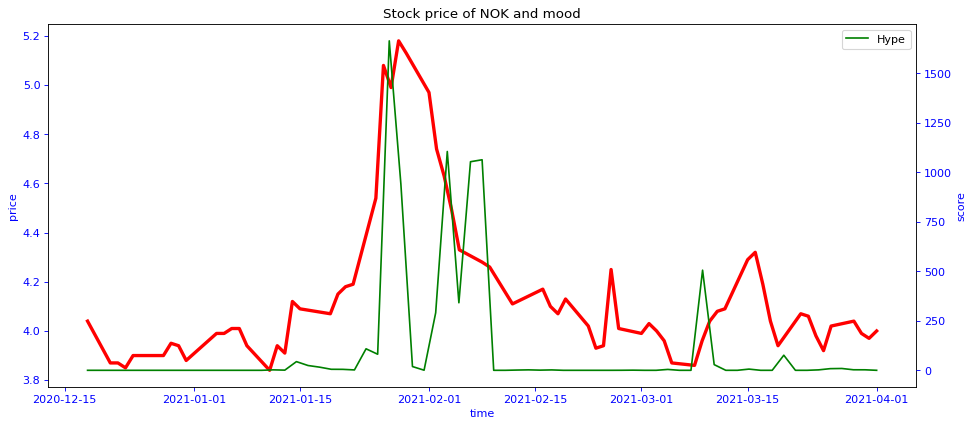

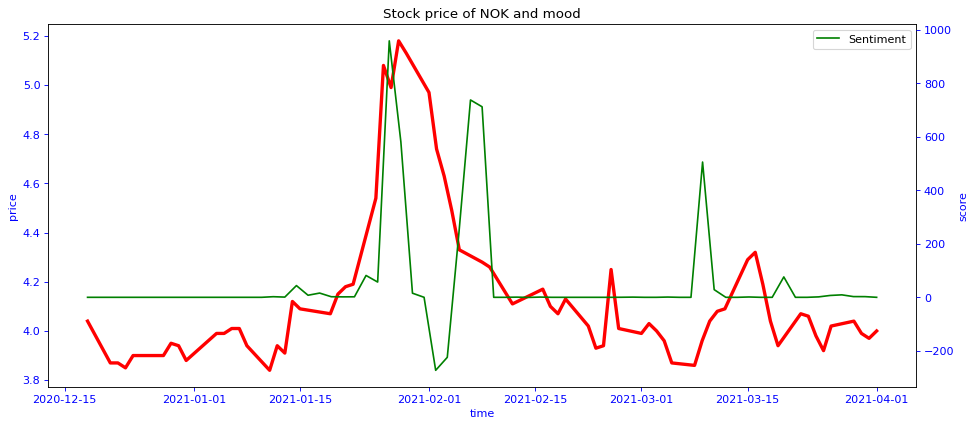

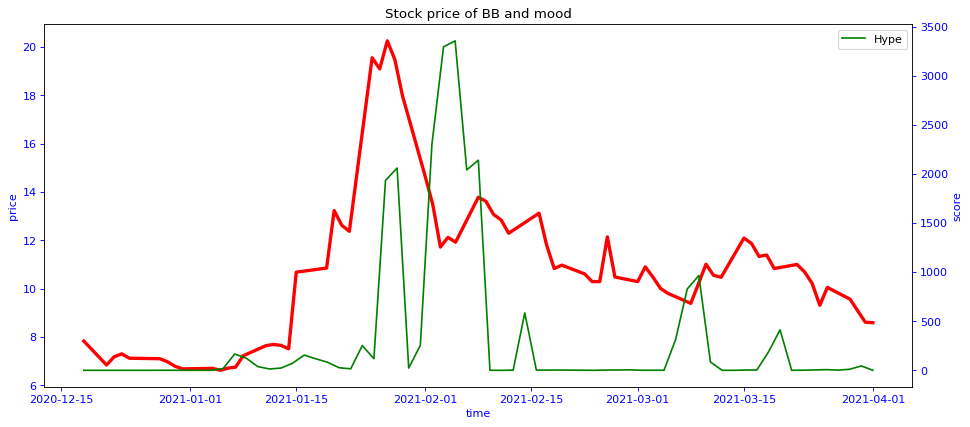

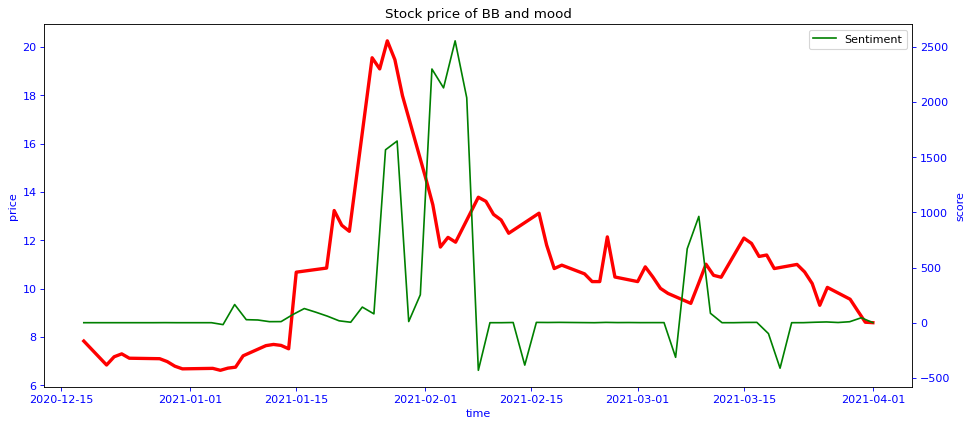

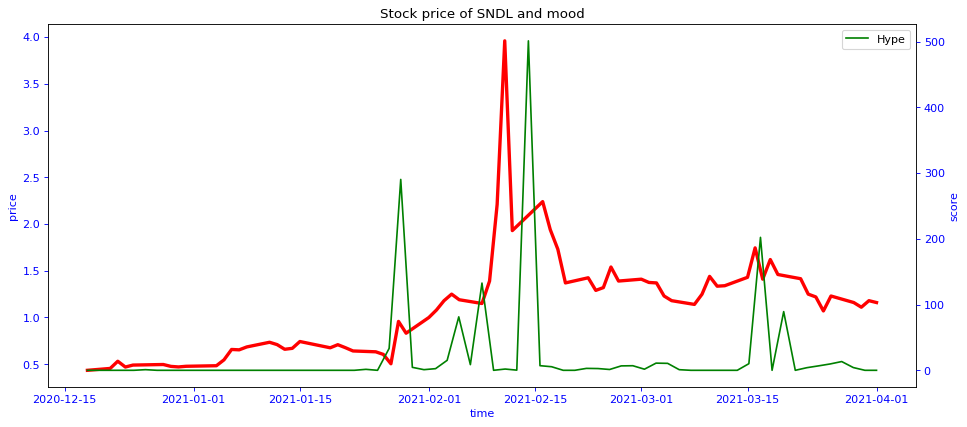

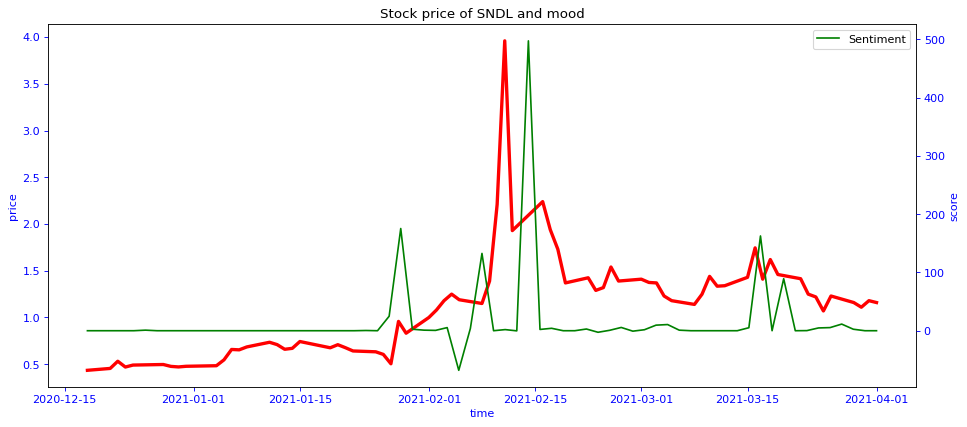

In [ ]:
# Plot "sentiment & price" and "hype & price" for 5 most common stocks 
for i in range(5):
    ticker = df_wsb_vader['ticker'].value_counts().keys()[i]
    sent, hype = get_attitude(ticker, df_wsb_vader)
    plot_mood(ticker, hype, 'Hype')
    plot_mood(ticker, sent, 'Sentiment')

##BERT Model
The BERT model is another popular model for NLP.

We will use two pre-trained BERT models: [distilbert-base-uncased-finetuned-sst-2-english](https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english), which is a general sentiment analysis model, and [FinBERT](https://huggingface.co/ProsusAI/finbert), which is a sentiment analysis model specifically for financial text. Both models are imported using the Hugging Face library.

###Sentiment Extraction

In [ ]:
!pip install transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

# Download both pre-trained sentiment models from Hugging Face
model_bert = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased-finetuned-sst-2-english')
tokenizer_bert = AutoTokenizer.from_pretrained('distilbert-base-uncased-finetuned-sst-2-english')

model_finbert = AutoModelForSequenceClassification.from_pretrained('ProsusAI/finbert')
tokenizer_finbert = AutoTokenizer.from_pretrained('ProsusAI/finbert')

# Set the models in evaluation mode to deactivate the DropOut modules
model_bert.eval()
model_finbert.eval()

# Test if we have a GPU available. If not, you can enable it with "Runtype >
# Change Runtime Type".
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
    print('GPU available.')

    # Create sentiment analysis pipeline. The "device=0" argument tells hugging face to put
    # the pipeline on the GPU.
    classify_bert = pipeline('sentiment-analysis', model=model_bert, tokenizer=tokenizer_bert, device=0)
    classify_finbert = pipeline('sentiment-analysis', model=model_finbert, tokenizer=tokenizer_finbert, device=0)
else:
    print('No GPU available.')

    # Create sentiment analysis pipeline (on CPU)
    classify_bert = pipeline('sentiment-analysis', model=model_bert, tokenizer=tokenizer_bert)
    classify_finbert = pipeline('sentiment-analysis', model=model_finbert, tokenizer=tokenizer_finbert)

     |████████████████████████████████| 2.0MB 12.3MB/s 
     |████████████████████████████████| 3.2MB 44.9MB/s 
     |████████████████████████████████| 870kB 43.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=a8f5328274bc0e081eed3d6fe41a92b540647c4d40f069f8d62c670be7b9c2d5
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses



No GPU available.


In [ ]:
def bert_classify_row(row):
    """Sentiment analysis of row using pre-trained BERT and FinBert model"""
    post = row[0]
    title = row[1]
    
    # Combine post and title
    text = title + ' ' + post
    text = text.replace('\n', ' ')

    # Label using BERT. Max text length of this BERT model is 512, so we truncate the text
    bert = classify_bert(text[:512])[0]
    finbert = classify_finbert(text[:512])[0]

    return bert['label'], bert['score'], finbert['label'].upper(), finbert['score']

In [ ]:
df_wsb_bert = df_wsb.copy()

# This is how we extract sentiment with BERT model. However, it also takes quite long
# (~10 min on GPU), so again we import the resulting dataframe instead.
#df_wsb_bert['BERT sent.'], df_wsb_bert['BERT score.'], df_wsb_bert['FinBERT sent.'], df_wsb_bert['FinBert score'] = zip(*df_wsb_bert[['selftext', 'title']].apply(classify_row, axis=1))
df_wsb_bert = pd.read_csv('https://drive.google.com/uc?export=download&id=1Ty6t4KfoMK4_ybnX_M2FDXZzEkJ4cxOm', index_col=0, parse_dates=['created_utc', 'date'])
df_wsb_bert.head()

,created_utc,num_comments,score,selftext,title,ticker,date,BERT sent.,BERT score,FinBERT sent.,FinBERT score
1,2021-01-01 00:05:29,5,1,We all know the short volume far exceeds 100% ...,"GME to 420.69, but only if we make it happen. ...",GME,2021-01-01,NEGATIVE,0.998464,NEUTRAL,0.832615
6,2021-01-01 00:45:03,8,1,"""Comrades, friends, ladies and gentlemen, gree...",Full text of Xi Jinping's 2021 New Year address,GDP,2021-01-01,POSITIVE,0.999628,NEUTRAL,0.649772
7,2021-01-01 00:49:32,0,1,"Gamestop colors: Red, White and Black\n\nHoust...",🚀🚀🚀🚀How have we been so fucking blind? GME is ...,GME,2021-01-01,NEGATIVE,0.997828,NEUTRAL,0.871579
9,2021-01-01 00:56:35,11,1,"Gamestop colors: Red, White and Black\n\nHoust...",GME is the Rockets 🚀🚀🚀🚀,GME,2021-01-01,NEGATIVE,0.997148,NEUTRAL,0.901515
10,2021-01-01 01:04:23,35,1,"Okay hear me out, WE ALL ALREADY FUCKING HAVE ...",STOP POSTING GME DD🚀🚀🚀,GME,2021-01-01,NEGATIVE,0.998292,NEUTRAL,0.791343


###Plots

In [ ]:
def get_attitude_bert(ticker='GME', df=df_wsb_bert):
    """Hype is a total popularity weighted with |sentiment|*number of upvotes,
    sentiment is total poluarity weighted with sentiment * number of upvotes for each day"""
    d = df[df['ticker']==ticker]
    sentiment = []
    hype = []
    for j in dates:
        date = d[d['date']==j]
        #mood = [date.iloc[i]['compound']*date.iloc[i]['score'] for i in range(len(date))]
        mood_bert = [date.iloc[i]['BERT score'] * date.iloc[i]['score'] if date.iloc[i]['BERT sent.'] == 'POSITIVE' else -date.iloc[i]['BERT score'] * date.iloc[i]['score'] for i in range(len(date))]
        mood_finbert = [date.iloc[i]['FinBERT score'] * date.iloc[i]['score'] if date.iloc[i]['FinBERT sent.'] == 'POSITIVE' else -date.iloc[i]['FinBERT score'] * date.iloc[i]['score'] if date.iloc[i]['FinBERT sent.'] == 'NEGATIVE' else 0 for i in range(len(date))]
        sentiment.append(sum(mood_bert) + sum(mood_finbert))
        absolute_sentiment_bert = [abs(i) for i in mood_bert]
        absolute_sentiment_finbert = [abs(i) for i in mood_finbert]
        hype.append(sum(absolute_sentiment_bert) + sum(absolute_sentiment_finbert))
    return sentiment, hype

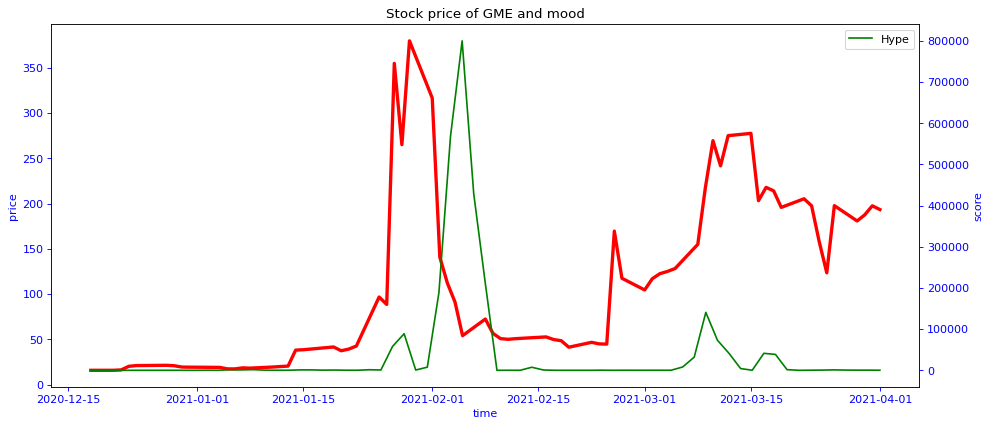

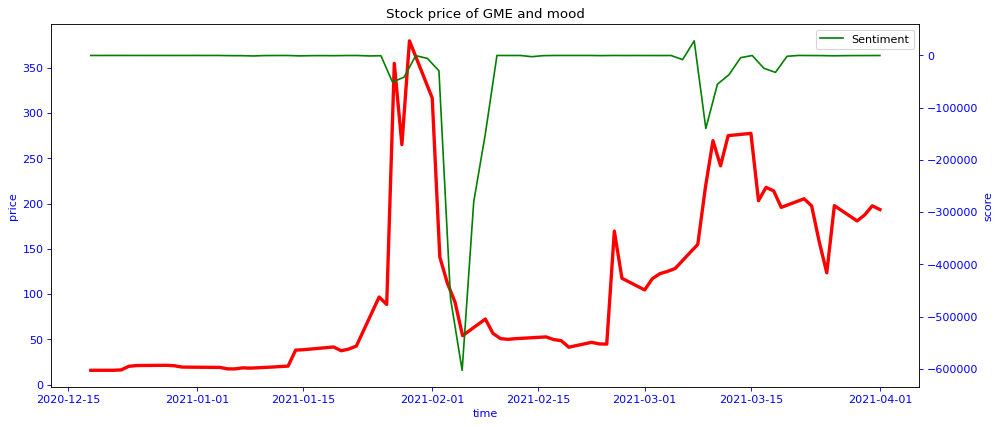

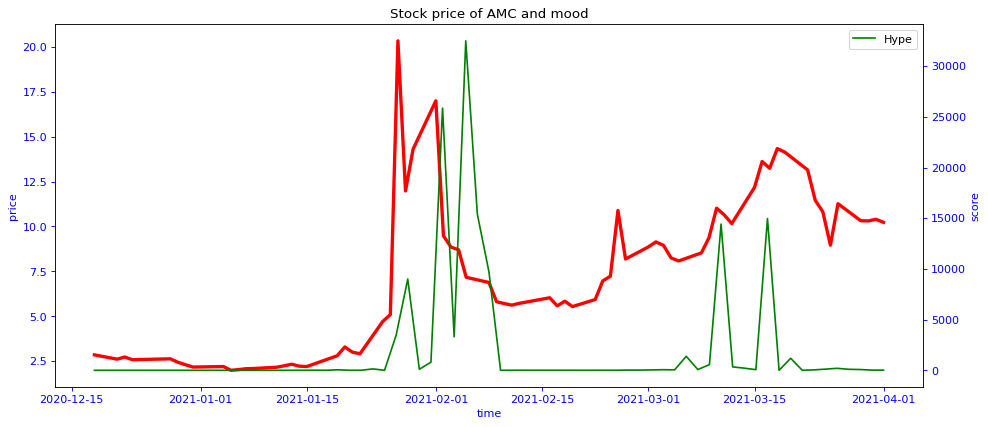

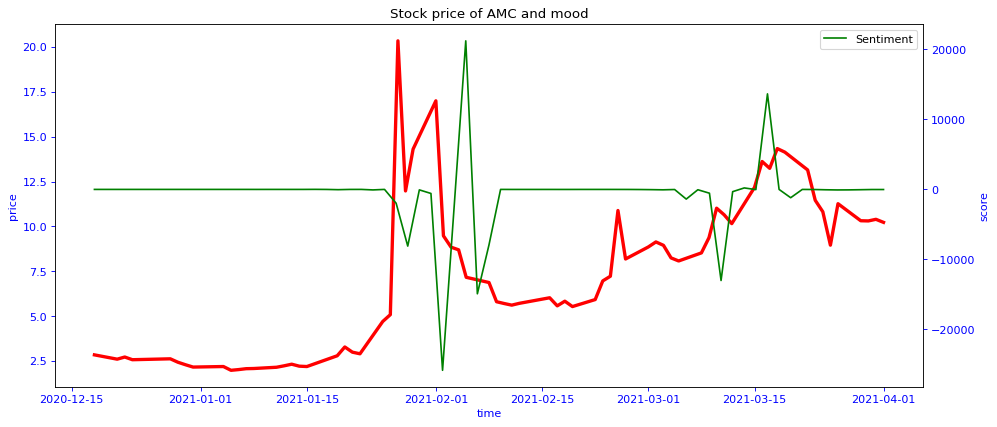

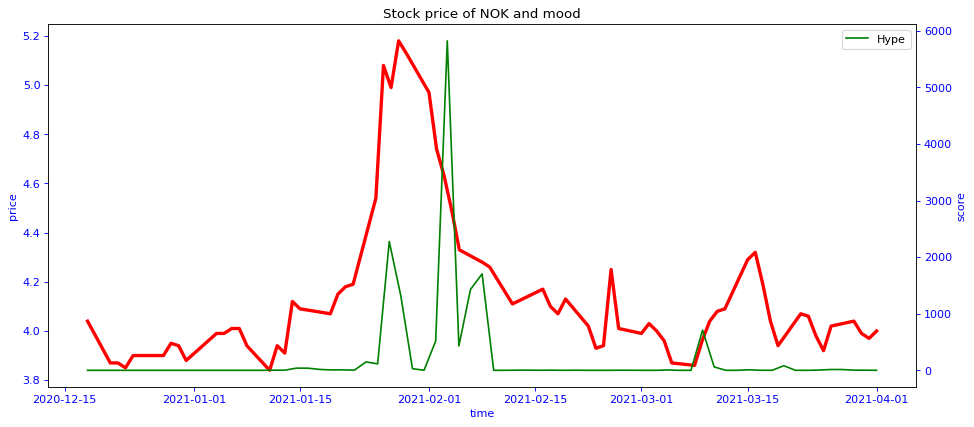

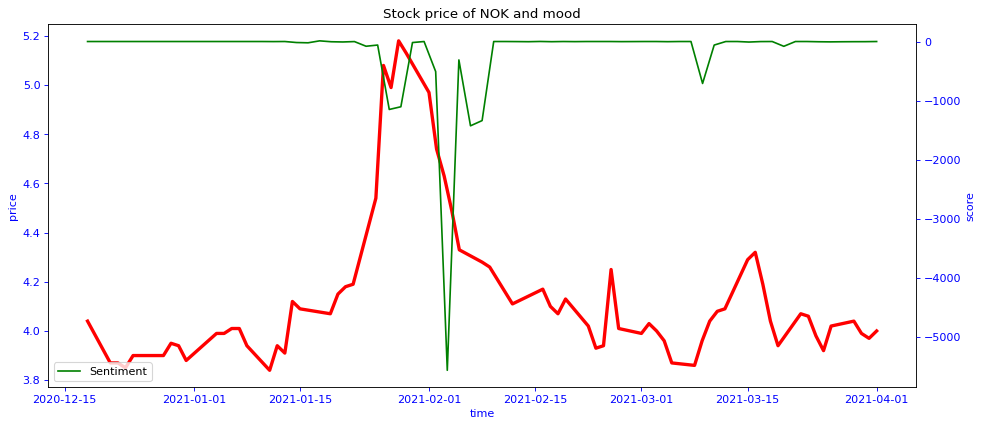

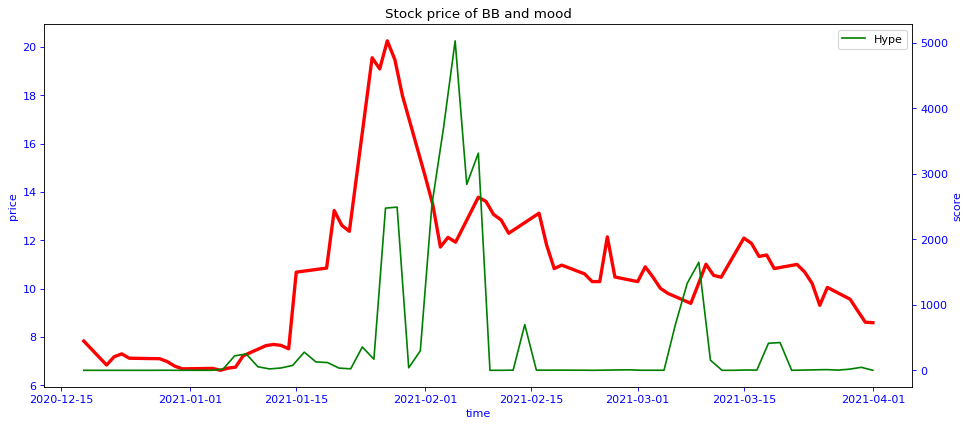

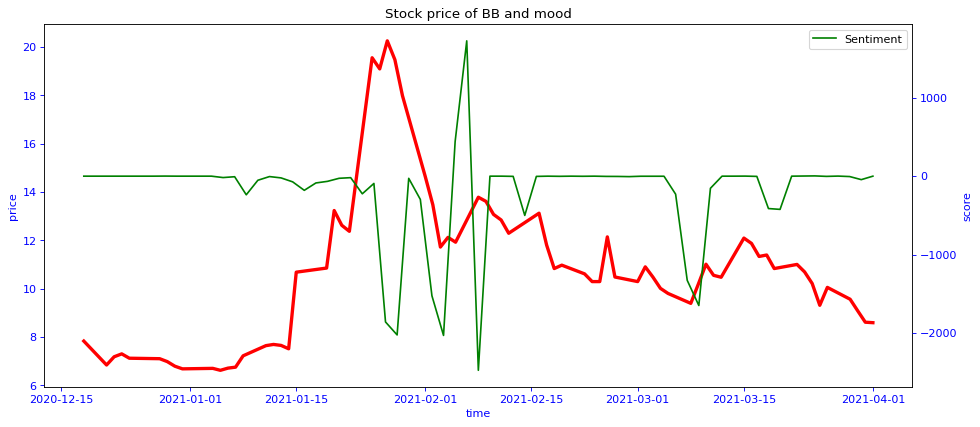

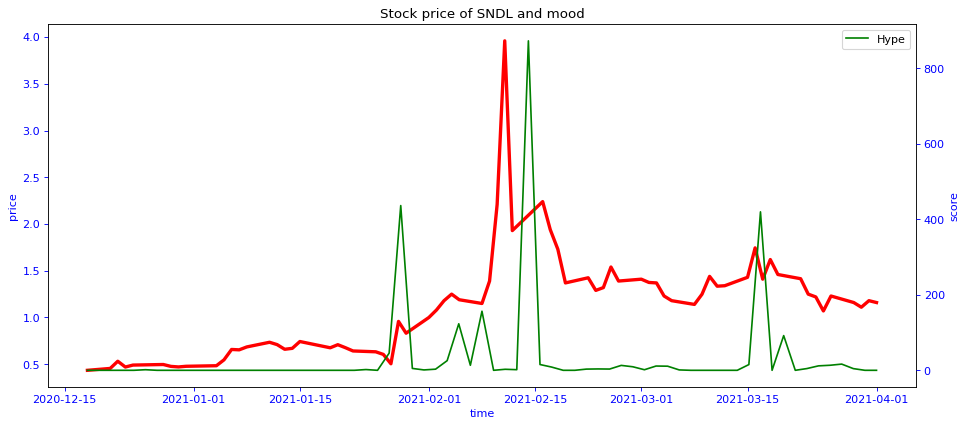

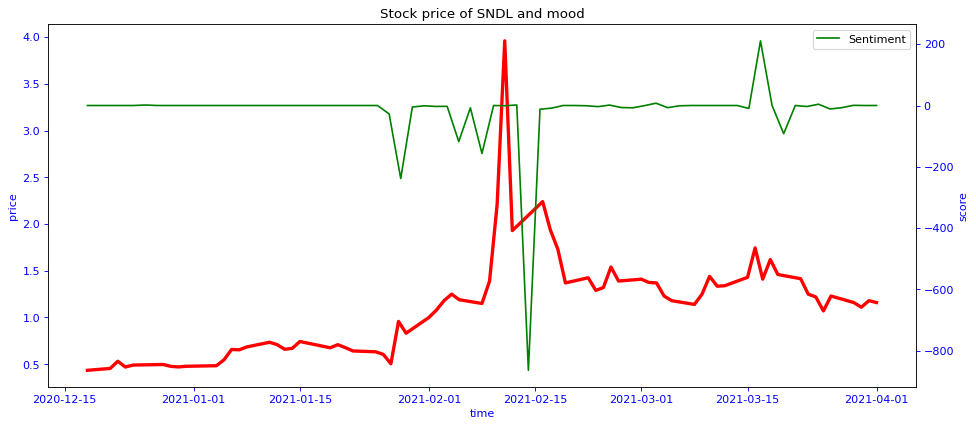

In [ ]:
# Plot "sentiment & price" and "hype & price" for 5 most common stocks 
for i in range(5):
    ticker = df_wsb_bert['ticker'].value_counts().keys()[i]
    sent, hype = get_attitude_bert(ticker, df_wsb_bert)
    plot_mood(ticker, hype, 'Hype')
    plot_mood(ticker, sent, 'Sentiment')

# Preparing Data for Learning

In [ ]:
import math
import sklearn
import sklearn.preprocessing

# Split data in 70%/15%/15% train/validation/test sets
valid_set_size_percentage = 15
test_set_size_percentage = 15 

In [ ]:
def clean_list(list):
    '''Replace any false values in a series with 0'''
    new_list = []
    for i in list:
        if i == False:
            new_list.append(0)
        else:
            new_list.append(i)
    return new_list


def build_aggregate(ticker='GME', df_wsb_bert=df_wsb_bert, df_wsb_vader=df_wsb_vader):
    '''Build an aggregate dataframe, with sentiment and other statistics for each hourly segment'''

    # Match time series of created posts with time in yf finance
    gme_bert = df_wsb_bert[df_wsb_bert['ticker']==ticker]
    gme_vader = df_wsb_vader[df_wsb_vader['ticker']==ticker]

    # Split dataset into daily & hourly segments
    dates_h = [str(date)[:13] for date in gme_bert['created_utc']]
    dates_h = list(dict.fromkeys(dates_h))
    dates = [str(date)[:10] for date in gme_bert['created_utc']] 
    dates = list(dict.fromkeys(dates))

    # Get stock data (open, close, high, low, volume, dividends & stock splits) for each daily & hourly segment
    g = yf.Ticker(ticker)
    d = g.history(period = '4mo', interval= '1h')

    d_corr_dates = pd.DataFrame(columns=['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'])
    for j in dates:
        for i in range(len((d['Open'].keys()))):
            if str(d['Open'].keys()[i])[:10] == j:
                d_corr_dates = d_corr_dates.append(d.iloc[i])

    market_open_dates = [str(d_corr_dates['Open'].keys()[i])[:10] for i in range(len(d_corr_dates))]
    market_open_dates = list(dict.fromkeys(market_open_dates))

    possible_hrs = []
    for i in dates:
        if market_open_dates.count(i) != 0:
            possible_hrs.append(i + ' 09')
            for j in range(10, 16):
                possible_hrs.append(i + ' ' + str(j))

    print('Possible hours equal to length of dataframe:', len(possible_hrs) == len(d_corr_dates))

    # Calculate sentiment and other stats per day
    bert_sent = []
    finbert_sent = []
    vader_sent = []
    num_posts = []
    num_upvotes = []
    num_upvotes_log = []
    avg_text_length = []
    avg_num_words = []
    avg_num_emojis = []
    dates = []
    hrs = []

    for j in possible_hrs:
        #upvotes=[gme['score'].iloc[i] for i in range(len(gme)) if gme['created_utc'].iloc[i][:13]==j]
        bert = 0
        finbert = 0
        vader = 0
        num_posts_hr = 0
        num_upvotes_hr = 0
        num_upvotes_log_hr = 0
        text_length_hr = 0
        num_words_hr = 0
        num_emojis_hr = 0
        
        for i in range(len(gme_bert)):
            if str(gme_bert['created_utc'].iloc[i])[:13]==j:
                if gme_bert['BERT sent.'].iloc[i] == 'POSITIVE':
                    bert += gme_bert['BERT score'].iloc[i] * math.log2(max(gme_bert['score'].iloc[i], 2))
                else:
                    bert -= gme_bert['BERT score'].iloc[i] * math.log2(max(gme_bert['score'].iloc[i], 2))
                
                if gme_bert['FinBERT sent.'].iloc[i] == 'POSITIVE':
                    finbert += gme_bert['FinBERT score'].iloc[i] * math.log2(max(gme_bert['score'].iloc[i], 2))
                elif gme_bert['FinBERT sent.'].iloc[i] == 'NEGATIVE':
                    finbert -= gme_bert['FinBERT score'].iloc[i] * math.log2(max(gme_bert['score'].iloc[i], 2))
        
        for i in range(len(gme_vader)):
            if str(gme_vader['created_utc'].iloc[i])[:13]==j:
                vader += gme_vader['compound'].iloc[i] * math.log(max(gme_vader['score'].iloc[i], .01))

                num_posts_hr += 1
                num_upvotes_hr += gme_vader['score'].iloc[i]
                num_upvotes_log_hr += math.log2(max(gme_vader['score'].iloc[i], 2))
                text_length_hr += gme_vader['text_lenght'].iloc[i]
                num_words_hr += gme_vader['num_of_words'].iloc[i]
                num_emojis_hr += gme_vader['num_of_emojis'].iloc[i]
        
        bert_sent.append(bert)
        finbert_sent.append(finbert)
        vader_sent.append(vader)
        num_posts.append(num_posts_hr)
        num_upvotes.append(num_upvotes_hr)
        num_upvotes_log.append(num_upvotes_log_hr)
        if num_posts_hr == 0:
            avg_text_length.append(0)
            avg_num_words.append(0)
            avg_num_emojis.append(0)
        else:
            avg_text_length.append(text_length_hr / num_posts_hr)
            avg_num_words.append(num_words_hr / num_posts_hr)
            avg_num_emojis.append(num_emojis_hr / num_posts_hr)
        dates.append(j[:10])
        hrs.append(int(j[11:]))

    d_corr_dates['date'] = clean_list(dates)
    d_corr_dates['hr'] = clean_list(hrs)
    d_corr_dates['BERT sent'] = clean_list(bert_sent)
    d_corr_dates['FinBERT sent'] = clean_list(finbert_sent)
    d_corr_dates['VADER sent'] = clean_list(vader_sent)
    d_corr_dates['num_posts'] = clean_list(num_posts)
    d_corr_dates['num_upvotes'] = clean_list(num_upvotes)
    d_corr_dates['num_upvotes_log'] = clean_list(num_upvotes_log)
    d_corr_dates['avg_text_length'] = clean_list(avg_text_length)
    d_corr_dates['avg_num_words'] = clean_list(avg_num_words)
    d_corr_dates['avg_num_emojis'] = clean_list(avg_num_emojis)

    d_corr_dates['CloseMinOpen'] = d_corr_dates['Close'] - d_corr_dates['Open']

    return d_corr_dates

In [ ]:
# The 'build_aggregate' method can be used to build a dataframe with aggregate
# data per hour. Once again, this takes quite long, so we will import a csv-file
# with pre-processed results for the last time
#d_corr_dates = build_aggregate('GME')

# File we processed before
d_corr_dates = pd.read_csv('https://drive.google.com/uc?export=download&id=1BuoCyPyIwme_sYwgnKIUKz9Z257c4jyj', index_col=0, parse_dates=['date'])
d_corr_dates.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,date,hr,BERT sent,FinBERT sent,VADER sent,num_posts,num_upvotes,num_upvotes_log,avg_text_length,avg_num_words,avg_num_emojis,CloseMinOpen
2021-03-12 11:30:00-05:00,284.320007,284.630005,272.230011,279.532288,2483148.0,0.0,0.0,2021-03-12,11,-0.037818,0.720327,0.000000,6,6,6.000000,585.500000,330.666667,3.000000,-4.787720
2021-03-12 12:30:00-05:00,279.060394,279.989990,264.414490,268.179901,2215067.0,0.0,0.0,2021-03-12,12,-1.702832,0.855238,0.692870,12,13,12.000000,517.166667,579.083333,4.000000,-10.880493
2021-03-12 13:30:00-05:00,268.450012,278.149994,267.850006,273.600006,2104199.0,0.0,0.0,2021-03-12,13,-15.404631,-1.363155,-6.113667,15,23,17.169925,726.866667,257.000000,3.533333,5.149994
2021-03-12 14:30:00-05:00,273.510010,281.690002,267.029999,271.480011,2652338.0,0.0,0.0,2021-03-12,14,-11.290435,0.000000,4.454843,5,35,13.299208,1004.200000,226.200000,2.800000,-2.029999
2021-03-12 15:30:00-05:00,271.480011,273.000000,262.269989,264.458893,1936522.0,0.0,0.0,2021-03-12,15,-16.150539,-0.726507,-2.250521,23,26,24.321928,789.434783,263.086957,0.608696,-7.021118


In [ ]:
d_corr_dates.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,hr,BERT sent,FinBERT sent,VADER sent,num_posts,num_upvotes,num_upvotes_log,avg_text_length,avg_num_words,avg_num_emojis,CloseMinOpen
count,322.000000,322.000000,322.000000,322.000000,3.220000e+02,322.0,322.0,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000
mean,100.089039,107.865293,92.306574,99.238539,6.936947e+06,0.0,0.0,12.000000,-19.996982,-2.599488,3.158490,21.158385,1990.881988,29.948002,536.607536,206.248617,2.113613,-0.850500
std,90.868989,100.066907,81.217255,89.427517,8.767498e+06,0.0,0.0,2.003113,77.782013,11.956370,13.981298,108.478617,8440.127900,115.953524,768.188133,317.993780,3.530126,23.508148
min,17.129999,17.504999,17.080000,17.119699,3.958890e+05,0.0,0.0,9.000000,-849.246772,-137.902934,-13.170758,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-265.859985
25%,39.159275,41.032475,38.505000,39.592499,1.507397e+06,0.0,0.0,10.000000,-11.489033,-0.821378,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.809977
50%,51.150000,54.904999,50.361151,51.250000,3.489407e+06,0.0,0.0,12.000000,-1.981428,0.000000,0.000000,2.000000,3.000000,3.000000,249.287879,155.809524,0.500000,-0.003300
75%,128.116724,143.004993,119.107500,128.695551,8.363090e+06,0.0,0.0,14.000000,0.000000,0.000000,0.558080,8.750000,32.250000,15.234662,789.483696,285.079944,3.067155,1.544002
max,398.000000,483.000000,320.000000,396.505005,6.069506e+07,0.0,0.0,15.000000,13.825880,12.412373,138.575103,1280.000000,89035.000000,1280.584963,5206.000000,4260.000000,29.000000,137.704407


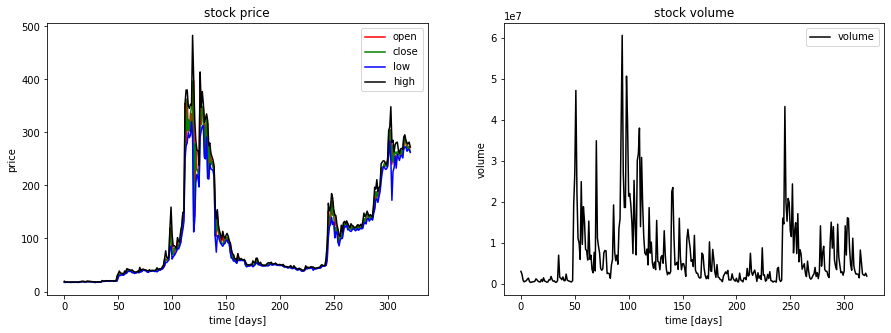

In [ ]:
plt.figure(figsize=(15, 5));
plt.subplot(1, 2, 1);
plt.plot(d_corr_dates['Open'].values, color='red', label='open')
plt.plot(d_corr_dates['Close'].values, color='green', label='close')
plt.plot(d_corr_dates['Low'].values, color='blue', label='low')
plt.plot(d_corr_dates['High'].values, color='black', label='high')
plt.title('stock price')
plt.xlabel('time [days]')
plt.ylabel('price')
plt.legend(loc='best')
#plt.show()

plt.subplot(1, 2, 2);
plt.plot(d_corr_dates['Volume'].values, color='black', label='volume')
plt.title('stock volume')
plt.xlabel('time [days]')
plt.ylabel('volume')
plt.legend(loc='best');

## Manipulate Data
- Choose a specific stock
- Drop feature: volume
- Normalize stock data
- Create train, validation and test data sets

In [ ]:
def normalize_data(df):
    '''Min-max normalize stock data'''
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    for col in df.columns:
        if col == 'CloseMinOpen':
            df[col] = list(map(lambda x: np.sign(x), df[col].values))
        else:
            df[col] = min_max_scaler.fit_transform(df[col].values.reshape(-1, 1))
    return df

def load_data(stock, seq_len):
    '''Create train, validation and test data given stock data and sequence length'''
    # Convert to numpy array
    data_raw = stock.values
    data = []
    
    # Create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len): 
        data.append(data_raw[index: index + seq_len])
    
    data = np.array(data);
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));  
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
    
    x_train = data[:train_set_size, :-1, :]
    y_train = data[:train_set_size, -1, :]
    y_train = y_train[:,-1].reshape(len(y_train), 1)
    
    x_valid = data[train_set_size:train_set_size+valid_set_size, :-1, :]
    y_valid = data[train_set_size:train_set_size+valid_set_size, -1, :]
    y_valid =  y_valid[:,-1].reshape(len(y_valid), 1)
    
    x_test = data[train_set_size+valid_set_size:, :-1, :]
    y_test = data[train_set_size+valid_set_size:, -1, :]
    y_test = y_test[:,-1].reshape(len(y_test), 1)
    return [x_train, y_train, x_valid, y_valid, x_test, y_test]

# Choose one stock
df_stock = d_corr_dates.copy()

#df_stock.drop(['Volume'],1,inplace=True)
df_stock.drop(['Dividends'],1,inplace=True)
df_stock.drop(['Stock Splits'],1,inplace=True)
#df_stock.drop(['Close'],1,inplace=True) # becasue we want linearly indep columns
#df_stock.drop(['Open'],1,inplace=True)
#df_stock.drop(['High'],1,inplace=True)
#df_stock.drop(['Low'],1,inplace=True)

cols = list(df_stock.columns.values)
print('df_stock.columns.values = ', cols)

# Normalize stock
df_stock_norm = df_stock.copy()
df_stock_norm = normalize_data(df_stock_norm)

# Create train, test data
seq_len = 30 # choose sequence length
x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(df_stock_norm, seq_len)
print('x_train.shape = ', x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ', x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ', y_test.shape)

df_stock.columns.values =  ['Open', 'High', 'Low', 'Close', 'Volume', 'date', 'hr', 'BERT sent', 'FinBERT sent', 'VADER sent', 'num_posts', 'num_upvotes', 'num_upvotes_log', 'avg_text_length', 'avg_num_words', 'avg_num_emojis', 'CloseMinOpen']
x_train.shape =  (204, 29, 17)
y_train.shape =  (204, 1)
x_valid.shape =  (44, 29, 17)
y_valid.shape =  (44, 1)
x_test.shape =  (44, 29, 17)
y_test.shape =  (44, 1)


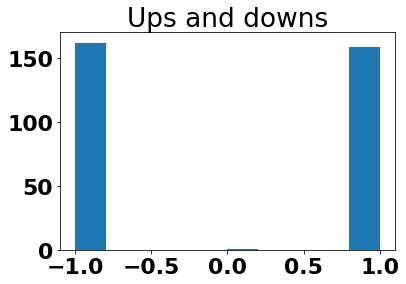

In [ ]:
plt.hist(df_stock_norm.CloseMinOpen.values)
plt.title("Ups and downs")

plt.show()

# RNN
Recurrent neural network with basic, LSTM, GRU cells

In [ ]:
## Basic Cell RNN in tensorflow
index_in_epoch = 0;
perm_array  = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)

def get_next_batch(batch_size):
    '''Function to get the next batch'''
    global index_in_epoch, x_train, perm_array   
    start = index_in_epoch
    index_in_epoch += batch_size
    
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array) # shuffle permutation array
        start = 0 # start next epoch
        index_in_epoch = batch_size
        
    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]

# parameters, acccuracy will increase for first 4 layers 
n_steps = seq_len - 1 
n_inputs = 17
n_neurons = 10
n_outputs = 1
n_layers = 3
learning_rate = 0.0005
batch_size = 15
n_epochs = 100
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]

from tensorflow.python.framework import ops
ops.reset_default_graph()
#tf.reset_default_graph()

#tf.compat.v1.disable_eager_execution()
X = tf.compat.v1.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.compat.v1.placeholder(tf.float32, [None, n_outputs])

# use Basic RNN Cell
layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.elu) for layer in range(n_layers)]

multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
#stacked_outputs = tf.compat.v1.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])

# Keep only last output of sequence
outputs = outputs[:, n_steps-1, :]

# Loss function = mean squared error (MSE)
loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

# Run graph
with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 
            print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(
                iteration*batch_size/train_set_size, mse_train, mse_valid))

    y_train_pred = sess.run(outputs, feed_dict={X: x_train})
    y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})

0.00 epochs: MSE train/valid = 1.165063/1.095982
5.00 epochs: MSE train/valid = 0.949146/1.028358
10.00 epochs: MSE train/valid = 0.924107/1.039167
15.00 epochs: MSE train/valid = 0.903070/1.035141
20.00 epochs: MSE train/valid = 0.881961/1.063216
25.00 epochs: MSE train/valid = 0.858962/1.114801
30.00 epochs: MSE train/valid = 0.833849/1.177039
35.00 epochs: MSE train/valid = 0.808502/1.196957
40.00 epochs: MSE train/valid = 0.783117/1.261032
45.00 epochs: MSE train/valid = 0.748556/1.296136
50.00 epochs: MSE train/valid = 0.714564/1.332313
55.00 epochs: MSE train/valid = 0.676865/1.361907
60.00 epochs: MSE train/valid = 0.624617/1.426644
65.00 epochs: MSE train/valid = 0.585756/1.647962
70.00 epochs: MSE train/valid = 0.553122/1.718537
75.00 epochs: MSE train/valid = 0.527903/1.825203
80.00 epochs: MSE train/valid = 0.482032/1.945173
85.00 epochs: MSE train/valid = 0.454731/2.068551
90.00 epochs: MSE train/valid = 0.435777/2.296134
95.00 epochs: MSE train/valid = 0.426899/2.392739


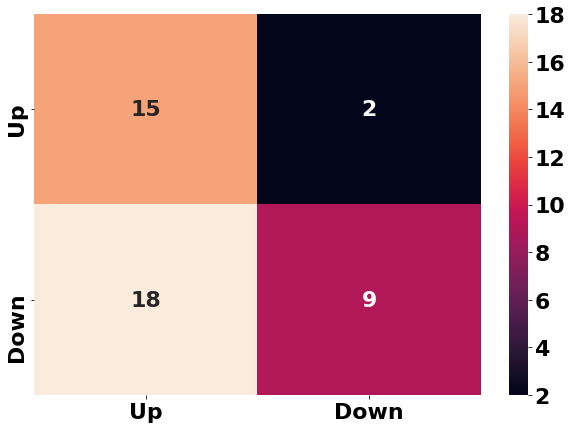

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib

cfm = confusion_matrix(y_test, list(map(lambda x: np.sign(x), y_test_pred)))
font = {
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)
classes = ['Up', 'Down']

df_cfm = pd.DataFrame(cfm, index = classes, columns = classes)
plt.figure(figsize = (10,7))
cfm_plot = sn.heatmap(df_cfm, annot=True)

In [98]:
# the most frequent value ocuurs in 
x = np.sum(np.equal(y_test,1))/len(y_test)
x = max(1-x, x)
# we predict correctly in 
y = np.sum(np.equal(np.sign(y_test[:,0]), np.sign(y_test_pred[:,0])))/len(y_test)

print('Naive strategy works in ' + str(z)[:5] + ' cases')
print('Our strategy works in ' + str(y)[:5] + ' cases')

Naive strategy works in 0.525 cases
Our strategy works in 0.545 cases


# Conclusion
As you can see, we have done a long process of scraping & analysing reddit posts, and then used it to train an RNN model. The results are not very flattering, unfortunately. Some possible future improvements include:
- Scraping more posts, to increase the dataset. Possible sources include other subreddits & twitter.
- Fine-tuning the sentiment analysis models to better reflect the specific language of our dataset.
- Fine-tuning the model parameters, possibly training different models altogether.